### Predicting Pokemon stats with ML

In this notebook we train an XGBoost model to predict one of the Pokemon stats given the other stats, the Pokemon type, and whether the Pokemon is Legendary.

To try to improve the model, we add new features of fractions of other stats and the sum of the other stats.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV
from scipy.optimize import curve_fit

In [3]:
data = pd.read_csv('../../data/poke_data/Pokemon.csv')
data.head()

,#,Name,Type 1,Type 2,Total,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Generation,Legendary
0,1,Bulbasaur,Grass,Poison,318,45,49,49,65,65,45,1,False
1,2,Ivysaur,Grass,Poison,405,60,62,63,80,80,60,1,False
2,3,Venusaur,Grass,Poison,525,80,82,83,100,100,80,1,False
3,3,VenusaurMega Venusaur,Grass,Poison,625,80,100,123,122,120,80,1,False
4,4,Charmander,Fire,NaN,309,39,52,43,60,50,65,1,False


In [3]:
# First drop the number, Name, Total, and Generation columns
data = data.drop(columns=['#', 'Name', 'Total', 'Generation'])
data.head()

,Type 1,Type 2,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Legendary
0,Grass,Poison,45,49,49,65,65,45,False
1,Grass,Poison,60,62,63,80,80,60,False
2,Grass,Poison,80,82,83,100,100,80,False
3,Grass,Poison,80,100,123,122,120,80,False
4,Fire,NaN,39,52,43,60,50,65,False


In [4]:
# Map Legendary to 1 and Non-Legendary to 0
data['Legendary'] = data['Legendary'].map({False: 0, True: 1})

# One-hot encode the Type 1 and Type 2 columns
data = data.fillna('None')  # Fill NaN values in Type columns with 'None'
data = pd.get_dummies(data, columns=['Type 1', 'Type 2'], drop_first=False)
data.head()

,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Legendary,Type 1_Bug,Type 1_Dark,Type 1_Dragon,...,Type 2_Grass,Type 2_Ground,Type 2_Ice,Type 2_None,Type 2_Normal,Type 2_Poison,Type 2_Psychic,Type 2_Rock,Type 2_Steel,Type 2_Water
0,45,49,49,65,65,45,0,False,False,False,...,False,False,False,False,False,True,False,False,False,False
1,60,62,63,80,80,60,0,False,False,False,...,False,False,False,False,False,True,False,False,False,False
2,80,82,83,100,100,80,0,False,False,False,...,False,False,False,False,False,True,False,False,False,False
3,80,100,123,122,120,80,0,False,False,False,...,False,False,False,False,False,True,False,False,False,False
4,39,52,43,60,50,65,0,False,False,False,...,False,False,False,True,False,False,False,False,False,False


To start we predict the Attack stat

In [5]:
# Split the data into features and target variable
X = data.drop(columns=['Attack'])
y = data['Attack']

# Add to X the fractions of each stat, like Defense/HP, making sure we don't also add HP/Defense
feature_stats = ['HP', 'Defense', 'Sp. Atk', 'Sp. Def', 'Speed']
for i, stat_1 in enumerate(feature_stats):
    for stat_2 in feature_stats[i+1:]:
        X[f'{stat_1}/{stat_2}'] = X[stat_1] / X[stat_2]

# Also add the sum of these stats (not including Attack!), as an indicator of overall strength
X['Stat_Sum'] = X[feature_stats].sum(axis=1)

X.head()

,HP,Defense,Sp. Atk,Sp. Def,Speed,Legendary,Type 1_Bug,Type 1_Dark,Type 1_Dragon,Type 1_Electric,...,HP/Sp. Atk,HP/Sp. Def,HP/Speed,Defense/Sp. Atk,Defense/Sp. Def,Defense/Speed,Sp. Atk/Sp. Def,Sp. Atk/Speed,Sp. Def/Speed,Stat_Sum
0,45,49,65,65,45,0,False,False,False,False,...,0.692308,0.692308,1.0,0.753846,0.753846,1.088889,1.000000,1.444444,1.444444,269
1,60,63,80,80,60,0,False,False,False,False,...,0.750000,0.750000,1.0,0.787500,0.787500,1.050000,1.000000,1.333333,1.333333,343
2,80,83,100,100,80,0,False,False,False,False,...,0.800000,0.800000,1.0,0.830000,0.830000,1.037500,1.000000,1.250000,1.250000,443
3,80,123,122,120,80,0,False,False,False,False,...,0.655738,0.666667,1.0,1.008197,1.025000,1.537500,1.016667,1.525000,1.500000,525
4,39,43,60,50,65,0,False,False,False,False,...,0.650000,0.780000,0.6,0.716667,0.860000,0.661538,1.200000,0.923077,0.769231,257


In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [7]:
# Define and train a test model
model = XGBRegressor(n_estimators=1000, learning_rate=0.01, random_state=42)
model.fit(X_train, y_train)

# Get the RSME
y_pred = model.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f'RMSE: {rmse:.2f}')

RMSE: 23.71


In [8]:
# Do a grid search to find the best hyperparameters
param_grid = {
    'n_estimators': [100, 500, 1000, 2000],
    'learning_rate': [0.005, 0.01, 0.05, 0.1]
}

model = XGBRegressor(random_state=42)
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, scoring='neg_mean_squared_error', cv=5, verbose=1)
grid_search.fit(X_train, y_train)
# Get the best parameters and the best score
best_params = grid_search.best_params_
best_score = np.sqrt(-grid_search.best_score_)
print(f'Best parameters: {best_params}')
print(f'Best RMSE: {best_score:.2f}')

Fitting 5 folds for each of 16 candidates, totalling 80 fits
Best parameters: {'learning_rate': 0.1, 'n_estimators': 1000}
Best RMSE: 23.16


In [9]:
best_model = grid_search.best_estimator_
# Evaluate the best model on the test set
y_pred_best = best_model.predict(X_test)
rmse_best = np.sqrt(mean_squared_error(y_test, y_pred_best))
print(f'Best model RMSE on test set: {rmse_best:.2f}')

Best model RMSE on test set: 23.59


This result is slightly better than what we found before. Let's also investigate the feature importance now.

In [10]:
# Get feature importances
importances = best_model.feature_importances_
feature_names = X.columns
importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
importance_df = importance_df.sort_values(by='Importance', ascending=False)
# Display the top 10 most important features
print("Top 10 most important features:")
print(importance_df.head(10))

print("Last 10 features:")
print(importance_df.tail(10))

Top 10 most important features:
            Feature  Importance
53         Stat_Sum    0.106936
29  Type 2_Fighting    0.081915
25      Type 2_Dark    0.056280
26    Type 2_Dragon    0.048834
8     Type 1_Dragon    0.044126
11  Type 1_Fighting    0.037144
48  Defense/Sp. Def    0.036483
41     Type 2_Steel    0.036345
21      Type 1_Rock    0.036066
0                HP    0.035816
Last 10 features:
          Feature    Importance
34  Type 2_Ground  3.102017e-03
19  Type 1_Poison  2.979820e-03
22   Type 1_Steel  1.960246e-03
28   Type 2_Fairy  1.908010e-03
13  Type 1_Flying  1.789490e-03
17     Type 1_Ice  1.781886e-03
10   Type 1_Fairy  1.230088e-03
38  Type 2_Poison  1.094562e-03
24     Type 2_Bug  9.126379e-04
37  Type 2_Normal  9.105815e-07


In [11]:
# Let's get rid of the features that have less than 0.01 importance
importance_df = importance_df[importance_df['Importance'] >= 0.01]
important_features = importance_df['Feature'].tolist()
X_important = X[important_features]
X_important.head()

,Stat_Sum,Type 2_Fighting,Type 2_Dark,Type 2_Dragon,Type 1_Dragon,Type 1_Fighting,Defense/Sp. Def,Type 2_Steel,Type 1_Rock,HP,...,Type 1_Psychic,Type 2_Rock,Speed,Sp. Atk,Type 1_Ground,HP/Speed,Sp. Def,Defense/Speed,Type 1_Fire,HP/Defense
0,269,False,False,False,False,False,0.753846,False,False,45,...,False,False,45,65,False,1.0,65,1.088889,False,0.918367
1,343,False,False,False,False,False,0.787500,False,False,60,...,False,False,60,80,False,1.0,80,1.050000,False,0.952381
2,443,False,False,False,False,False,0.830000,False,False,80,...,False,False,80,100,False,1.0,100,1.037500,False,0.963855
3,525,False,False,False,False,False,1.025000,False,False,80,...,False,False,80,122,False,1.0,120,1.537500,False,0.650407
4,257,False,False,False,False,False,0.860000,False,False,39,...,False,False,65,60,False,0.6,50,0.661538,True,0.906977


In [13]:
X_important_train, X_important_test, y_important_train, y_important_test = train_test_split(X_important, y, test_size=0.25, random_state=42)

model_important = XGBRegressor(n_estimators=1000, learning_rate=0.1, random_state=42)
model_important.fit(X_important_train, y_important_train)
y_important_pred = model_important.predict(X_important_test)
rmse_important = np.sqrt(mean_squared_error(y_important_test, y_important_pred))
print(f'RMSE with important features: {rmse_important:.2f}')

RMSE with important features: 23.65


In [14]:
# That's about the same, try Grid Search
model_important = XGBRegressor(random_state=42)
grid_search_important = GridSearchCV(estimator=model_important, param_grid=param_grid, scoring='neg_mean_squared_error', cv=5, verbose=1)
grid_search_important.fit(X_important_train, y_important_train)
best_params_important = grid_search_important.best_params_
best_score_important = np.sqrt(-grid_search_important.best_score_)
print(f'Best parameters with important features: {best_params_important}')
print(f'Best RMSE with important features: {best_score_important:.2f}')

best_model_important = grid_search_important.best_estimator_
y_important_pred_best = best_model_important.predict(X_important_test)
rmse_important_best = np.sqrt(mean_squared_error(y_important_test, y_important_pred_best))
print(f'Best model with important features RMSE on test set: {rmse_important_best:.2f}')

Fitting 5 folds for each of 16 candidates, totalling 80 fits
Best parameters with important features: {'learning_rate': 0.01, 'n_estimators': 2000}
Best RMSE with important features: 22.59
Best model with important features RMSE on test set: 23.96


Overall it seems like the best performance it with all features and hyperparameters 0.1, 1000. Let's then do a more precise grid search with all features around those values.

In [15]:
param_grid_precise = {
    'n_estimators': [800, 900, 1000, 1100, 1200],
    'learning_rate': [0.08, 0.09, 0.1, 0.11, 0.12]
}

model_precise = XGBRegressor(random_state=42)
grid_search_precise = GridSearchCV(estimator=model_precise, param_grid=param_grid_precise, scoring='neg_mean_squared_error', cv=5, verbose=1)
grid_search_precise.fit(X_train, y_train)
best_params_precise = grid_search_precise.best_params_
best_score_precise = np.sqrt(-grid_search_precise.best_score_)
print(f'Best parameters with precise search: {best_params_precise}')
print(f'Best RMSE with precise search: {best_score_precise:.2f}')

best_model_precise = grid_search_precise.best_estimator_
y_precise_pred = best_model_precise.predict(X_test)
rmse_precise = np.sqrt(mean_squared_error(y_test, y_precise_pred))
print(f'Best model with precise search RMSE on test set: {rmse_precise:.2f}')

Fitting 5 folds for each of 25 candidates, totalling 125 fits
Best parameters with precise search: {'learning_rate': 0.09, 'n_estimators': 1200}
Best RMSE with precise search: 23.04
Best model with precise search RMSE on test set: 23.45


In [7]:
# maybe more than 1200 is still better
param_grid_precise = {
    'n_estimators': [1200, 1300, 1400],
    'learning_rate': [0.08, 0.09, 0.1]
}

model_precise = XGBRegressor(random_state=42)
grid_search_precise = GridSearchCV(estimator=model_precise, param_grid=param_grid_precise, scoring='neg_mean_squared_error', cv=5, verbose=1)
grid_search_precise.fit(X_train, y_train)
best_params_precise = grid_search_precise.best_params_
best_score_precise = np.sqrt(-grid_search_precise.best_score_)
print(f'Best parameters with precise search: {best_params_precise}')
print(f'Best RMSE with precise search: {best_score_precise:.2f}')

best_model_precise = grid_search_precise.best_estimator_
y_precise_pred = best_model_precise.predict(X_test)
rmse_precise = np.sqrt(mean_squared_error(y_test, y_precise_pred))
print(f'Best model with precise search RMSE on test set: {rmse_precise:.2f}')

Fitting 5 folds for each of 9 candidates, totalling 45 fits
Best parameters with precise search: {'learning_rate': 0.09, 'n_estimators': 1300}
Best RMSE with precise search: 23.04
Best model with precise search RMSE on test set: 23.45


It seems like the best we can achieve is an error of 23.45. This is a small improvement on the error of about 24 we had before.

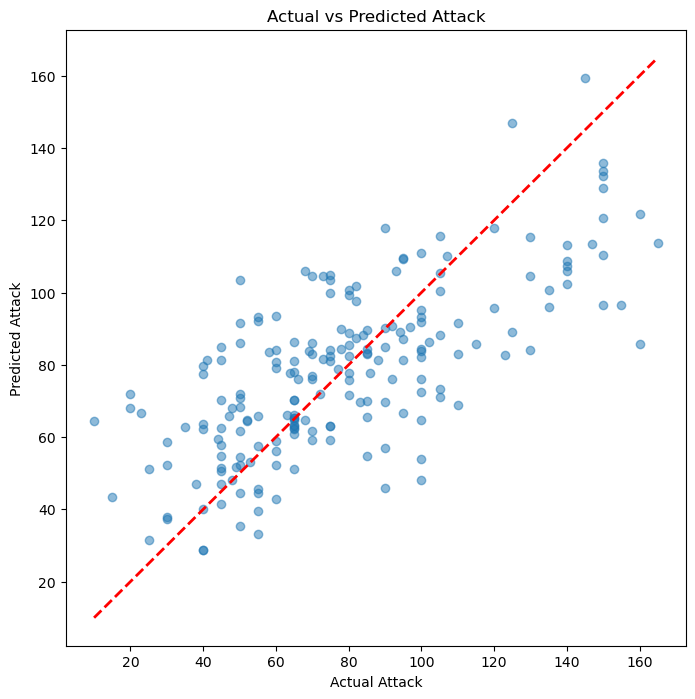

In [18]:
# Let's finally plot the predicted Attack against the actual Attack
plt.figure(figsize=(8, 8))
plt.scatter(y_test, y_precise_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)  # Diagonal line, perfect prediction line
plt.xlabel('Actual Attack')
plt.ylabel('Predicted Attack')
plt.title('Actual vs Predicted Attack')
plt.show()

It seems like the model has a tendency to predict a higher Attack stat when it is actually small, while it predicts a lower Attack when it is actually large. We can see this by adding a line fit:

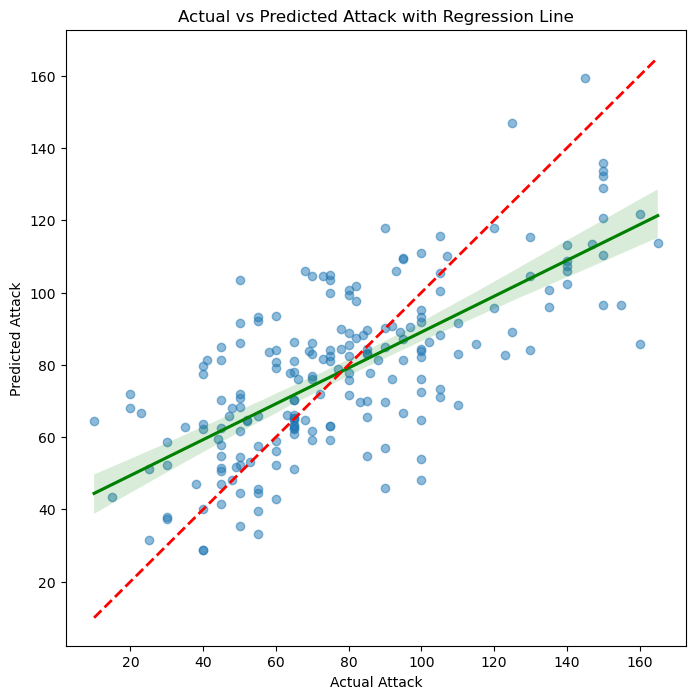

In [19]:
plt.figure(figsize=(8, 8))
sns.regplot(x=y_test, y=y_precise_pred, scatter_kws={'alpha':0.5}, line_kws={'color':'green'})
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)  # Diagonal line, perfect prediction line
plt.xlabel('Actual Attack')
plt.ylabel('Predicted Attack')
plt.title('Actual vs Predicted Attack with Regression Line')
plt.show()

In [10]:
# To try and counteract this, we can try to use a logarithmic scale for the Attack values
y_log = np.log(y)
X_train_log, X_test_log, y_train_log, y_test_log = train_test_split(X, y_log, test_size=0.25, random_state=42)

model_log = XGBRegressor(n_estimators=1000, learning_rate=0.1, random_state=42)
model_log.fit(X_train_log, y_train_log)

y_log_pred = model_log.predict(X_test_log)
y_pred_log = np.exp(y_log_pred)

rmse_log = np.sqrt(mean_squared_error(y_test, y_pred_log))
print(f'RMSE with log-transformed target: {rmse_log:.2f}')
# It does not perform a miracle, no it likely won't help much

RMSE with log-transformed target: 24.76


Something else to try is to fit this line to the data and apply that as a sort of model correction. So if $y_1$ is the output of the XGBoost model, we will obtain the final prediction $y_2$ by doing

\begin{equation}
    y_2 = a \cdot y_1 + b,
\end{equation}

where $a$ and $b$ are determined by fitting the XGBoost output of the training data to the known training values, as a straight line.

Linear model parameters: a=1.0000, b=-0.0006


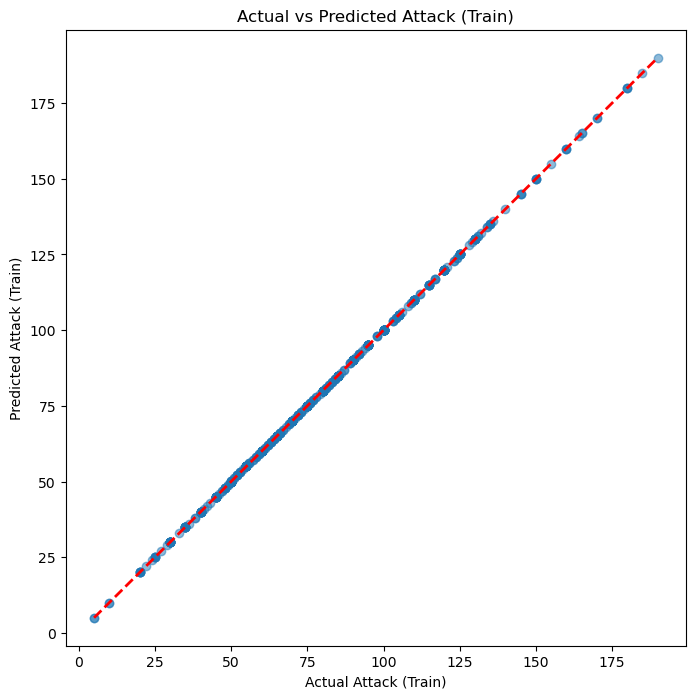

In [22]:
y_train_precise_pred = best_model_precise.predict(X_train)

def linear_model(x, a, b):
    return a * x + b

# Fit a linear model to the training predictions, with x=y_train_precise_pred and y=y_train
params, _ = curve_fit(linear_model, y_train_precise_pred, y_train)
print(f'Linear model parameters: a={params[0]:.4f}, b={params[1]:.4f}')

# Those parameters are essentially a perfect diagonal line, indicating a perfect fit to the training data; check a plot
plt.figure(figsize=(8, 8))
plt.scatter(y_train, y_train_precise_pred, alpha=0.5)
plt.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 'r--', lw=2)  # Diagonal line, perfect prediction line
plt.ylabel('Predicted Attack (Train)')
plt.xlabel('Actual Attack (Train)')
plt.title('Actual vs Predicted Attack (Train)')
plt.show()
# So that training result is too good, overfitting is likely happening

RMSE with early stopping: 23.53


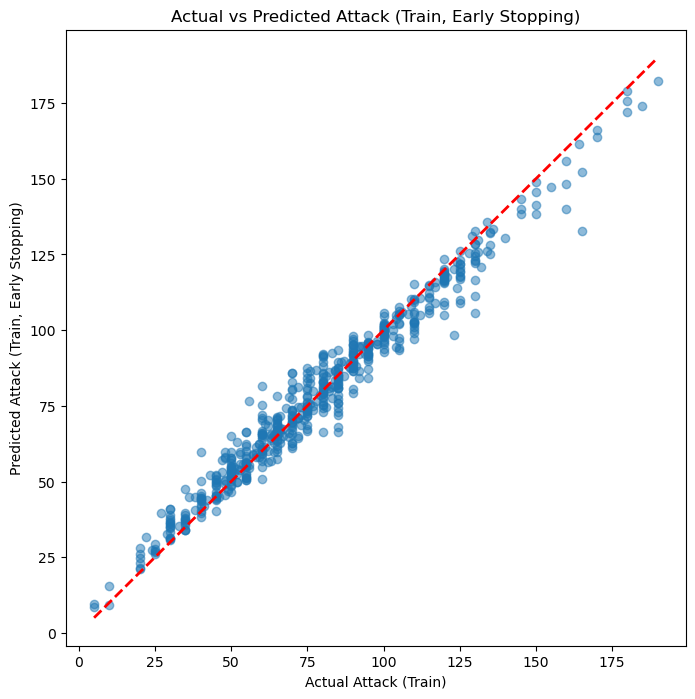

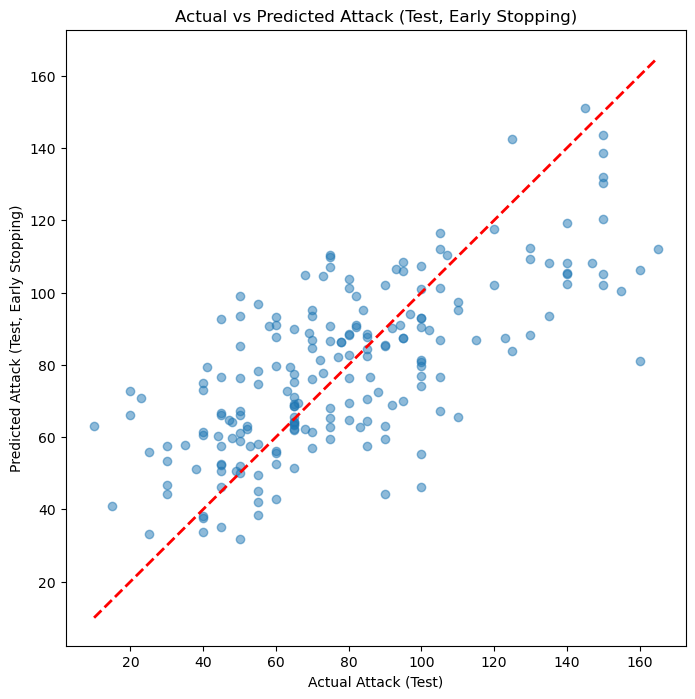

In [ ]:
# To prevent overfitting we can try to train a model with early stopping
model_early_stopping = XGBRegressor(n_estimators=1000, learning_rate=0.1, random_state=42, early_stopping_rounds=5)
model_early_stopping.fit(X_train, y_train, eval_set=[(X_test, y_test)], verbose=False)
y_early_stopping_pred = model_early_stopping.predict(X_test)
rmse_early_stopping = np.sqrt(mean_squared_error(y_test, y_early_stopping_pred))
print(f'RMSE with early stopping: {rmse_early_stopping:.2f}')

y_train_early_stopping_pred = model_early_stopping.predict(X_train)
plt.figure(figsize=(8, 8))
plt.scatter(y_train, y_train_early_stopping_pred, alpha=0.5)
plt.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 'r--', lw=2)  # Diagonal line, perfect prediction line
plt.ylabel('Predicted Attack (Train, Early Stopping)')
plt.xlabel('Actual Attack (Train)')
plt.title('Actual vs Predicted Attack (Train, Early Stopping)')
plt.show()

plt.figure(figsize=(8, 8))
plt.scatter(y_test, y_early_stopping_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)  # Diagonal line, perfect prediction line
plt.ylabel('Predicted Attack (Test, Early Stopping)')
plt.xlabel('Actual Attack (Test)')
plt.title('Actual vs Predicted Attack (Test, Early Stopping)')
plt.show()

So here we see that the training predictions look a lot better, not perfectly fitting to the data, so early stopping helps. However, it does not solve the test predictions, and initially does not lead to a smaller error. Let's test if any hyperparameters allow us to get an error below 23.45 with early stopping.

In [ ]:
lr_tests = [0.01, 0.05, 0.06, 0.08, 0.09, 0.1, 0.11, 0.12, 0.13, 0.14, 0.15, 0.2, 0.3]

# I still haven't figured out how to do early stopping with GridSearchCV, so let's do it manually
for lr in lr_tests:
    model = XGBRegressor(n_estimators=1000, learning_rate=lr, random_state=42, early_stopping_rounds=5)
    model.fit(X_train, y_train, eval_set=[(X_test, y_test)], verbose=False)
    y_pred = model.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    print(f'Learning Rate: {lr}, RMSE: {rmse:.2f}')

Learning Rate: 0.01, RMSE: 24.03
Learning Rate: 0.05, RMSE: 24.08
Learning Rate: 0.06, RMSE: 24.08
Learning Rate: 0.08, RMSE: 23.85
Learning Rate: 0.09, RMSE: 23.56
Learning Rate: 0.1, RMSE: 23.53
Learning Rate: 0.11, RMSE: 23.61
Learning Rate: 0.12, RMSE: 23.92
Learning Rate: 0.13, RMSE: 23.31
Learning Rate: 0.14, RMSE: 24.02
Learning Rate: 0.15, RMSE: 23.91
Learning Rate: 0.2, RMSE: 23.67
Learning Rate: 0.3, RMSE: 24.19


Final model RMSE: 23.31
Final linear model parameters: a=1.0564, b=-4.4332


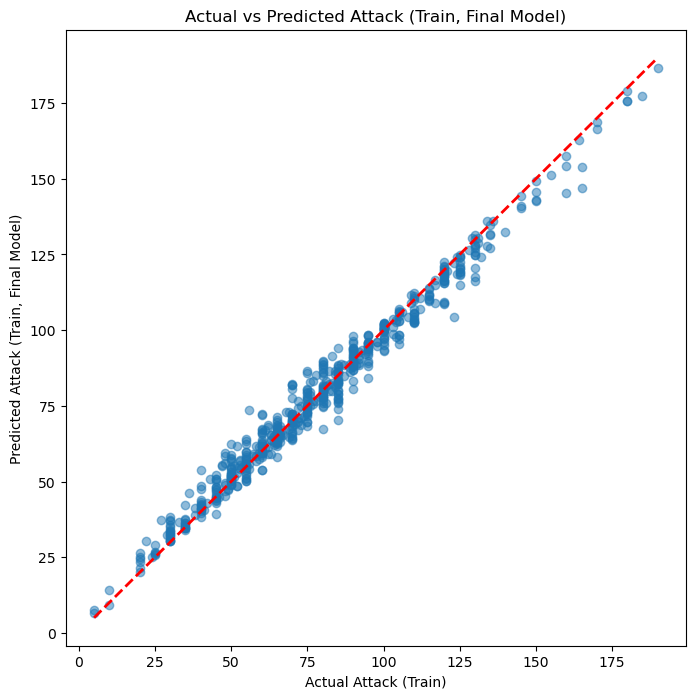

In [34]:
# It seems like with a learning rate of 0.13 we get a slightly better result
model_final = XGBRegressor(n_estimators=1000, learning_rate=0.13, random_state=42, early_stopping_rounds=5)
model_final.fit(X_train, y_train, eval_set=[(X_test, y_test)], verbose=False)
y_final_pred = model_final.predict(X_test)
rmse_final = np.sqrt(mean_squared_error(y_test, y_final_pred))
print(f'Final model RMSE: {rmse_final:.2f}')

# Now try to apply the linear fit to this
y_train_final_pred = model_final.predict(X_train)
params_final, _ = curve_fit(linear_model, y_train_final_pred, y_train)
print(f'Final linear model parameters: a={params_final[0]:.4f}, b={params_final[1]:.4f}')

plt.figure(figsize=(8, 8))
plt.scatter(y_train, y_train_final_pred, alpha=0.5)
plt.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 'r--', lw=2)  # Diagonal line, perfect prediction line
plt.ylabel('Predicted Attack (Train, Final Model)')
plt.xlabel('Actual Attack (Train)')
plt.title('Actual vs Predicted Attack (Train, Final Model)')
plt.show()

Final model RMSE with correction: 23.27


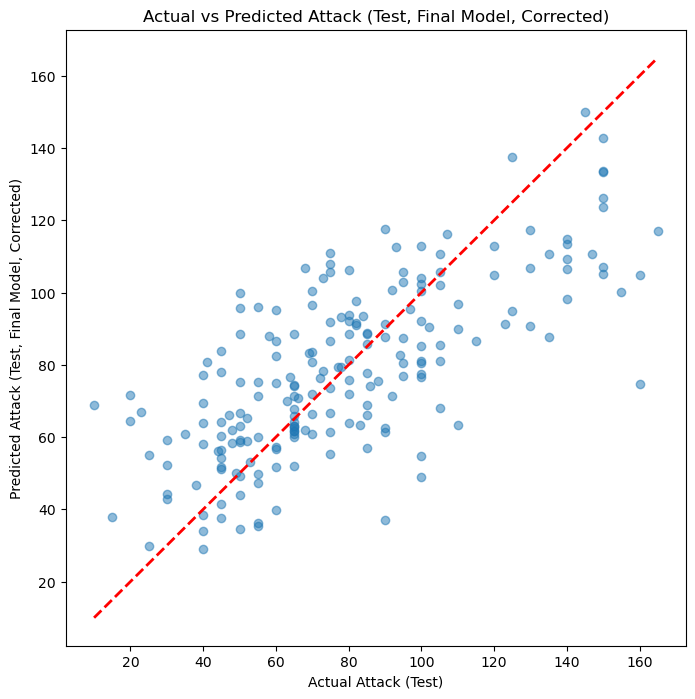

In [36]:
# See if it improves on the test set
y_final_pred_corrected = params_final[0] * y_final_pred + params_final[1]
rmse_final_corrected = np.sqrt(mean_squared_error(y_test, y_final_pred_corrected))
print(f'Final model RMSE with correction: {rmse_final_corrected:.2f}')

plt.figure(figsize=(8, 8))
plt.scatter(y_test, y_final_pred_corrected, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)  # Diagonal line, perfect prediction line
plt.ylabel('Predicted Attack (Test, Final Model, Corrected)')
plt.xlabel('Actual Attack (Test)')
plt.title('Actual vs Predicted Attack (Test, Final Model, Corrected)')
plt.show()

So this linear fit does slightly improve the error, but really not be all that much. Also, the tendency we saw before is still visible here, so it does not solve it properly. This is because the effect is much stronger in the test predictions than in the training predictions, even with early stopping.

In the end, we can conclude that the available features are not strong enough to get a good enough prediction of a single stat that I find satisfying, although they do hold some predictive power.

There might be a possibility to improve the model by adding more features. For instance the evolutionary stage of a Pokemon; an evolved Pokemon is generally stronger and this could serve as an indicator of overall stat magnitude. (One would have to manually add this information for every Pokemon though, a fair bit of work.) Or one could inspect of there is a relation between stats and the Pokemon's height or weight, as generally bigger Pokemon are stronger. (This information does exist in the games.)